# Estimating The Mass of a Globular Cluster

## Background


NGC 2419 is among the most distant globular clusters in the Milky Way, situated approximately 90 kiloparsecs from the Galactic center. Its unusually large size and isolated location have led to suggestions that it may be the remnant core of a dwarf galaxy accreted by the Milky Way. With a half-light radius of approximately 25 parsecs, NGC 2419 significantly deviates from the more compact structure typically observed in Galactic globular clusters. A detailed study of this object can yield valuable insights into the formation and evolutionary processes of the Galactic outer halo.

The primary objective of this study is to estimate the mass of NGC 2419 using observational data acquired with the Steward Observatory 61-inch Kuiper Telescope. We employ the mass estimator proposed by Wolf et al. (2010) and compare our results to previously published values, such as those reported by Baumgardt et al. (2009).


## Header

In [228]:
#header of imports
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.wcs import WCS

from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip

from astropy import units as u
from photutils.background import Background2D, MedianBackground
from photutils.aperture import aperture_photometry, CircularAperture

import astropy as ap
import astrometry

solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={1,3},
    )
)

import logging
!pip install astroalign
from reproject import reproject_interp
from collections import defaultdict
from scipy.ndimage import shift as ndi_shift
from astropy.coordinates import SkyCoord, match_coordinates_sky

from astropy.visualization import PercentileInterval, AsinhStretch, ImageNormalize
import astroalign as aa
%matplotlib inline


INFO:root:loaded 96 index files


## Methods and Discussion


To achieve a mass estimate with sufficient accuracy, we implemented several standard techniques in observational astronomy. First, an observational strategy was devised to ensure adequate data coverage and quality. This strategy included the use of all available photometric filters (U, B, V, and R) to capture a comprehensive range of stellar populations within the cluster. For each filter, both short- and long-exposure images were acquired to optimize dynamic range and sensitivity.

Following data acquisition, the raw images were processed through a standard data reduction pipeline, comprising bias subtraction, flat-field correction, and background subtraction. The bias and flat-field corrections performed as expected; however, significant difficulties arose during background subtraction. In particular, the densely populated central regions of NGC 2419 introduced substantial complexity, making reliable background estimation challenging. The overlapping stellar profiles hindered accurate sky aperture placement, leading to unphysical results in the background-subtracted frames. Consequently, we opted to proceed with photometric analysis based on the flat-field-corrected images, which provided more reliable measurements under these conditions. Future improvements may be achieved through more sophisticated background modeling techniques capable of handling crowded fields.

Subsequent processing steps involved the application of a star-finding algorithm to generate stacked images for each filter set. These stacks were then used to construct curves of growth, from which the cluster's half-light radius was empirically determined.

Finally, we employed the mass estimator proposed by Wolf et al. (2010) to calculate the mass enclosed within the half-light radius, using our measured values as inputs. From this, we derived an estimate for the total mass of NGC 2419, which we then compared with previously established values in the literature.


## Functions

### Data Reduction Pipeline

In [233]:
#defining a function that corrects the bias:
def BiasCorrection(filenum):
    #Defining bias_image
    filename = 'bias.fits'
    hdu = fits.open(filename)[0]
    bias_image = hdu.data
    hdr = hdu.header

    #create a dictionary for the corrected files
    corrected = {}

    #loops over the range filenum
    for i in range(1, filenum+1):
        filename = f'23feb.{i:04d}.fits'
        hdu = fits.open(filename)[0]
        image = hdu.data
        hdr = hdu.header
        
        #subtract and store in dictionary
        bias = image - bias_image
        filt = hdr.get('FILTER')
        exposure = hdr.get('EXPTIME')
        corrected[filename] = {
        'data': bias,
        'filter': filt,
        'exposure': exposure,
        'img': hdu
        }

    #returns the dictionary
    return corrected

In [234]:
#Defining function that flatfields:
def Flatfielding(corrected):
    #create a dictionary of the filters
    flatdict = {
        'Harris-R': 'rflat.fits',
        'Harris-V': 'vflat.fits',
        'Harris-B': 'bflat.fits',
        'Bessell-U': 'uflat.fits',
    }
    #interate across dict
    for file, info in corrected.items():
        data = info['data']
        filt = info['filter']
        #grab flat field fits
        flat = flatdict.get(filt)

        hdu = fits.open(flat)[0]
        flatdata = hdu.data

        #adds flatdata to our dict
        info['flatdata'] = data / flatdata
    #returns the dict
    return corrected

In [235]:
#Defining function that finds background
def Background(corrected):
    #loops over each file and grabs their info
    for file, info in corrected.items():
        #grabs the flatdata
        image = info['flatdata']
        
        #fits background
        mean, median, std = sigma_clipped_stats(image, sigma=3.0)
        sigma_clip = SigmaClip(sigma=3.0)
        bkg_estimator = MedianBackground()
        bkg = Background2D(image, (50, 50), filter_size=(3,3),sigma_clip=sigma_clip,bkg_estimator=bkg_estimator)
        
        #Subtracts background
        image = image - bkg.background
        #adds background to dict
        info['bgsub'] = image
    #returns dict
    return corrected

### Starfinding

In [237]:
#Defining function that finds stars:
def Starfinding(corrected):
    #blank dictionary for star data
    tables = {}

    #loops through each file in dict and grabs their info
    for file, info in corrected.items():
        #workbook 6 stuff
        image = info['flatdata']
        
        bkg_sigma = mad_std(image)

        daofind = DAOStarFinder(fwhm=4.0, threshold=100.0 * bkg_sigma)

        sources = daofind(image)

        for col in sources.colnames:
            sources[col].info.format = '%.8g' 
            
        sources = sources[sources['ycentroid'] >= 1]
        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

        radii = [3.0, 4.0, 5.0,7.0,10.0,15.0,25.0,40.0]

        apertures = [CircularAperture(positions, r=r) for r in radii]
        
        phot_table = aperture_photometry(image, apertures)
        #adds tables to the dictionary
        tables[file] = phot_table
    #returns a dict of phot_tables, and radii if necessary
    return tables, radii

### Grouping and Stacking

In [239]:
#Define astropy function
def astropy(groups):
    #workbook 7 stuff
    logging.getLogger().setLevel(logging.INFO)
    unit = 'pix'
    #loops over each filter and grabs their files
    for filt, files in groups.items():
        #loops over each file and grabs their info
        for file, info in files.items():
            #workbook 7 stuff
            x = info['position'][0]
            y = info['position'][1]
            stars = [(x[i], y[i]) for i in range(0,len(x))]
            solution = solver.solve(
                stars=stars,
                size_hint=None,
                position_hint=astrometry.PositionHint(
                    ra_deg=114.73,
                    dec_deg=38,
                    radius_deg=1.0),
        solution_parameters=astrometry.SolutionParameters(),
)    
            if solution.has_match():
                #adds wcs to dict
                info['wcs'] = solution.best_match().astropy_wcs()
    #returns the dict
    return groups

In [240]:
#stacking
def Stack(filt):
    #setting up a reference image
    ref_file, first_info = next(iter(filt.items()))
    ref_wcs   = first_info['wcs']
    ref_shape = first_info['flatdata'].shape
    img_aligned = first_info['flatdata']
    #loops through all files and stacks
    for  files, file in filt.items():
        img = file['flatdata']
        img_aligned, _ = aa.register(img_aligned, img, detection_sigma=3.0)
    #returns the image
    return img_aligned

### Half-light Radius Computation

In [242]:
#half life radius
def hlr(image, x0, y0):
    #pixel coords
    y, x = np.indices(image.shape)
    #distance from center
    r = np.hypot(x - x0, y - y0)
    #radial step
    dr = 1.0

    #masks left half of image
    mask = (x <= x0)

    #set radii and get cumflux for left half
    #set radii max to 1400 to get whole image which is slightly larger than needed but its fine like this
    radii = np.arange(0, 1400, dr)
    cumflux = np.array([np.nansum(image[(r <= rad) & mask]) for rad in radii])
    
    #get total and half flux
    total_flux = cumflux[-1]
    half_flux = total_flux / 2.0

    #finds where cumflux >= half_flux
    idx = np.searchsorted(cumflux, half_flux)
    #grabs radii at idx value
    R_half = radii[idx]

    #plot
    plt.figure(figsize=(6,4))
    plt.plot(radii, cumflux, 'o-', label='Curve of Growth')
    plt.axvline(R_half, color='red', linestyle='--', label=f'R₁/₂ = {R_half:.1f} px')
    plt.xlabel("Radius (pixels)")
    plt.ylabel("Cumulative Flux")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    #returns value for half light radius
    return R_half

### Wolfs (2019) Mass estimator (based on Baumgardt, H., et al. (2009) values for the velocity dispersion)

In [244]:
#mass
def mass(r_half):
    #arcsec/pix
    plate_scale = 0.15
    # distance to cluster in pc
    distance   = 88500
    #grab half life
    r_pix = r_half
    
    # convert to arcsec
    r_arcsec = r_pix * plate_scale
    # convert to radians
    r_rad = (r_arcsec * u.arcsec).to(u.rad).value
    # physical radius (pc)
    r_pc = distance * r_rad
    
    #G in  pc·(km/s)^2 / M_sun
    G = 4.302e-3
    
    #physical half-light radius in pc
    hlr_pc = r_pc
    # km/s, e.g. from spectra
    sigma = 3.7 #based on Baumgardt (2009)
    
    #Wolf et al. mass estimator
    M_half = 4 * sigma**2 * hlr_pc / G
    M_full = 2.0 * M_half    
    print(f"M_1/2 = {M_half:.2e} M_sun")
    print(f"M_1/2*2 = {M_half*2.0:.2e} M_sun")

    return M_full

## Running Code

In [246]:
#running some code
#bias correction dict
corrected = BiasCorrection(56)
#flatfielding dict
corrected = Flatfielding(corrected)
#grabs tables and radii from starfinding
tables, radii = Starfinding(corrected)

In [247]:
#group starfinding info with files and files with filters
groups = {
        'Harris-R': {},
        'Harris-V': {},
        'Harris-B': {},
        'Bessell-U': {}
    }
#goes over each file in dict and adds to appropriate filter with info
for file, info in corrected.items():
        filt = info['filter']
        tbl = tables[file]
        x = tbl['xcenter'].value    
        y = tbl['ycenter'].value  
        if filt == 'Harris-R':
            groups[filt][file] = info
        elif filt == 'Harris-V':
            groups[filt][file] = info
        elif filt == 'Harris-B':
            groups[filt][file] = info
        elif filt == 'Bessell-U':
            groups[filt][file] = info
        groups[filt][file]['position']=[x,y]

In [248]:
#LONG CODE RUNS ASTROPY FOR EACH FILE AND STORES WCS (runs for like 5 mins)
groups = astropy(groups)

INFO:root:solve 1: start
INFO:root:solve 1: slice=[0, 25) (1 / 1), index="5200/index-5201-05.fits" (1 / 2)
INFO:root:solve 1: logodds=142.777, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.8879, scale=0.425611, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=143.271, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.8879, scale=0.424874, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=134.66, matches=24, conflicts=0, distractors=4, ra=114.538, dec=38.8881, scale=0.428704, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=144.971, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.8883, scale=0.42792, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=151.965, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.888, scale=0.425242, index="5200/index-5201-05.fits"
INFO:root:solve 1: logodds=148.687, matches=25, conflicts=0, distractors=3, ra=114.538, dec=38.888, scale=0.427714, index="5200/index-5201-05.fits"
INF

#### Final Stacked Images for Each Filter

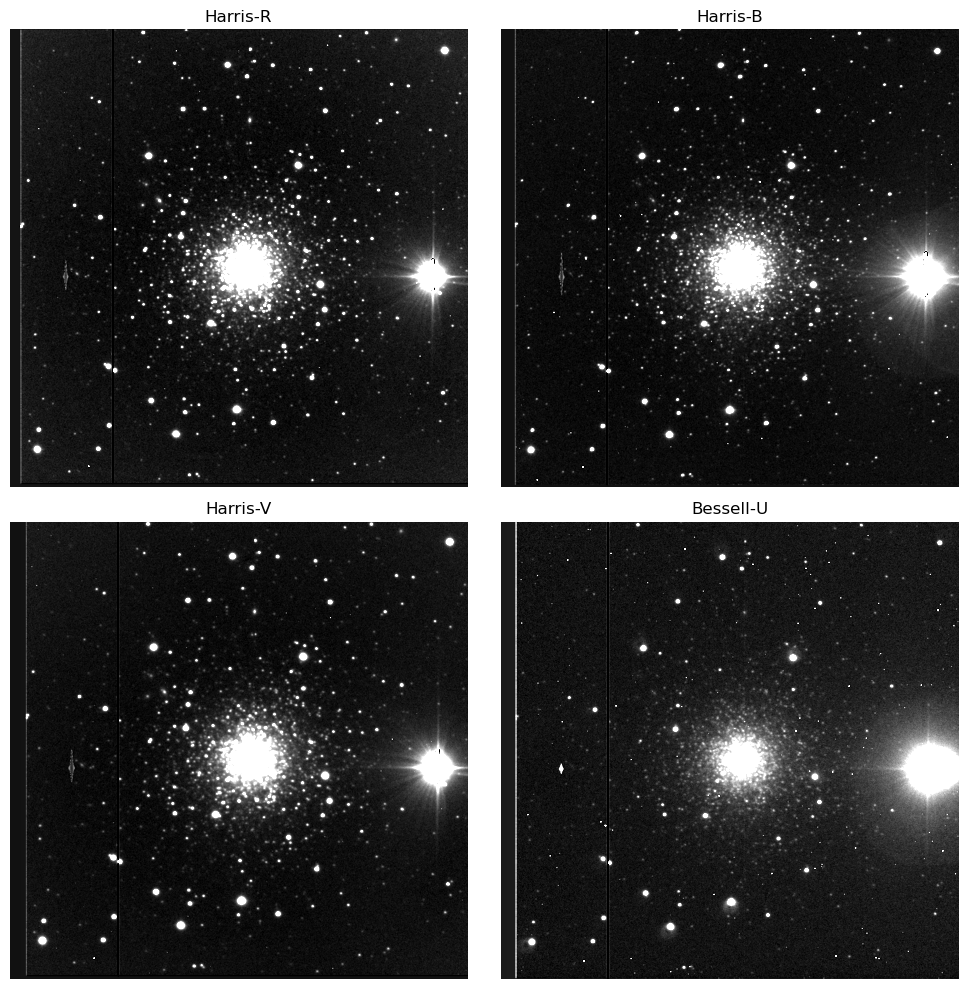

In [250]:
#stacks images for each filter
HR = Stack(groups['Harris-R'])
HB = Stack(groups['Harris-B'])
HV = Stack(groups['Harris-V'])
BU = Stack(groups['Bessell-U'])

#creates a dict with the stacked images
stacks = {
    'Harris-R': HR,
    'Harris-B': HB,
    'Harris-V': HV,
    'Bessell-U': BU
}

# Compute vmin and vmax and normalizes
Rvmin, Rvmax = np.percentile(HR, (2, 98))
Rnorm = ImageNormalize(vmin=Rvmin, vmax=Rvmax)
Bvmin, Bvmax = np.percentile(HB, (2, 98))
Bnorm = ImageNormalize(vmin=Bvmin, vmax=Bvmax)
Vvmin, Vvmax = np.percentile(HV, (2, 98))
Vnorm = ImageNormalize(vmin=Vvmin, vmax=Vvmax)
Uvmin, Uvmax = np.percentile(BU, (2, 98))
Unorm = ImageNormalize(vmin=Uvmin, vmax=Uvmax)

#graphs
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(HR, cmap='gray', norm=Rnorm, origin='lower')
axes[0, 0].set_title("Harris-R")
axes[0, 0].axis('off')

axes[0, 1].imshow(HB, cmap='gray', norm=Bnorm, origin='lower')
axes[0, 1].set_title("Harris-B")
axes[0, 1].axis('off')

axes[1, 0].imshow(HV, cmap='gray', norm=Vnorm, origin='lower')
axes[1, 0].set_title("Harris-V")
axes[1, 0].axis('off')

axes[1, 1].imshow(BU, cmap='gray', norm=Unorm, origin='lower')
axes[1, 1].set_title("Bessell-U")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

#### Curve-of-Growth plots with Half-light Radius marked

Harris-R


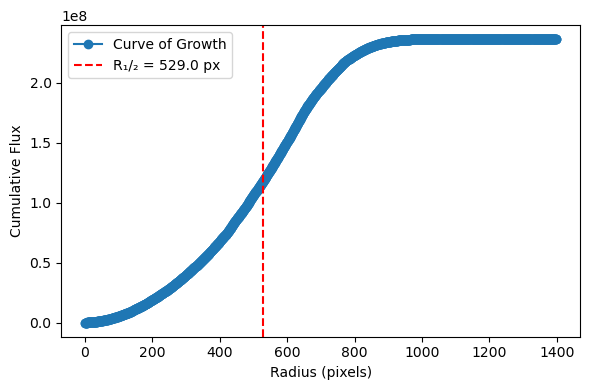

Half-light radius: 529.0 pixels

Harris-B


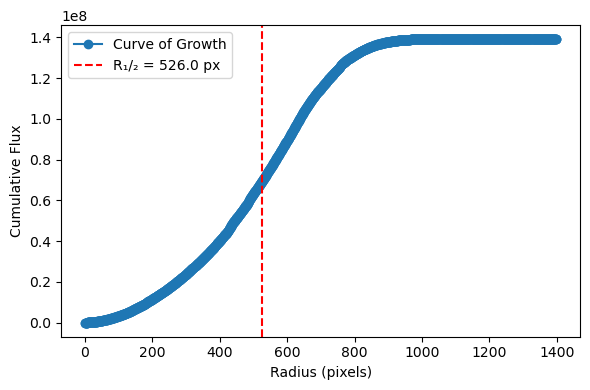

Half-light radius: 526.0 pixels

Harris-V


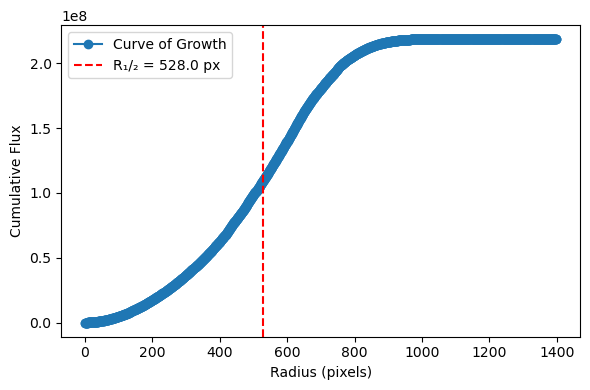

Half-light radius: 528.0 pixels

Bessel-U


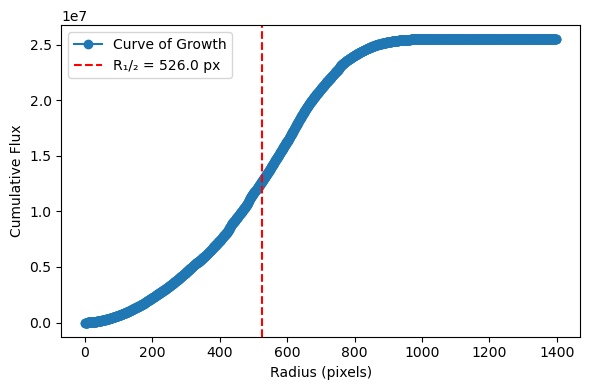

Half-light radius: 526.0 pixels


In [252]:
#x0 and y0 was determined manually and is about the center of the cluster
#determines HLR and graphs
print("Harris-R")
Rhalf = hlr(HR, x0=650, y0=620)
print(f"Half-light radius: {Rhalf:.1f} pixels")
print()
print("Harris-B")
Bhalf = hlr(HB, x0=650, y0=620)
print(f"Half-light radius: {Bhalf:.1f} pixels")
print()
print("Harris-V")
Vhalf = hlr(HV, x0=650, y0=620)
print(f"Half-light radius: {Vhalf:.1f} pixels")
print()
print("Bessel-U")
Uhalf = hlr(BU, x0=650, y0=620)
print(f"Half-light radius: {Uhalf:.1f} pixels")

#### Estimated Half-light Radius Mass and Total Mass for Each Filter

In [254]:
#calculates mass and prints
print("Harris-R")
MR = mass(Rhalf)
print("Harris-B")
BR = mass(Bhalf)
print("Harris-V")
VR = mass(Vhalf)
print("Bessel-U")
UR = mass(Uhalf)

Harris-R
M_1/2 = 4.33e+05 M_sun
M_1/2*2 = 8.67e+05 M_sun
Harris-B
M_1/2 = 4.31e+05 M_sun
M_1/2*2 = 8.62e+05 M_sun
Harris-V
M_1/2 = 4.33e+05 M_sun
M_1/2*2 = 8.65e+05 M_sun
Bessel-U
M_1/2 = 4.31e+05 M_sun
M_1/2*2 = 8.62e+05 M_sun


#### Functions to Spread Uncertainty and Join Radii Values

In [256]:
def radius_and_mass_uncertainty(radii, sigma, delta_sigma):
    """
    Compute the mean half-light radius and its uncertainty from a list of radii,
    then propagate the uncertainty in velocity dispersion into the mass estimate.

    Parameters
    ----------
    radii : array-like
        List or array of half-light radius measurements (in pixels).
    sigma : float
        Velocity dispersion (in km/s).
    delta_sigma : float
        Uncertainty in the velocity dispersion (in km/s).

    Returns
    -------
    mean_radius : float
        The mean of the input radii.
    delta_radius : float
        The standard error of the mean radius.
    frac_mass_uncertainty : float
        The fractional uncertainty in the mass estimate,
        computed as sqrt((2*delta_sigma/sigma)**2 + (delta_radius/mean_radius)**2).
    """
    radii = np.asarray(radii, dtype=float)
    n = radii.size
    
    # Mean radius
    mean_radius = radii.mean()
    
    # Sample standard deviation
    s = radii.std(ddof=1)
    
    # Standard error of the mean
    delta_radius = s / np.sqrt(n)
    
    # Fractional uncertainty in mass
    frac_mass_uncertainty = np.sqrt((2 * delta_sigma / sigma)**2 + (delta_radius / mean_radius)**2)
    
    return mean_radius, delta_radius, frac_mass_uncertainty

def format_scientific_with_uncertainty(value, uncertainty):
    exponent = int(np.floor(np.log10(value)))
    scale = 10**exponent
    scaled_value = value / scale
    scaled_uncertainty = uncertainty / scale
    return f"{scaled_value:.2f} ± {scaled_uncertainty:.2f} × 10^{exponent}"

#Defining radii and sigma uncertainties
radii_px = [Rhalf, Bhalf, Vhalf, Uhalf]  # measurements in pixels
sigma_val = 4.14  # km/s
delta_sigma_val = 0.48  # km/s
mean_r, delta_r, frac_unc = radius_and_mass_uncertainty(radii_px, sigma_val, delta_sigma_val)

#Defining M_tot
M_tot = mass(mean_r)
delta_mass = frac_unc*10e5 # Output from radius_and_mass_uncertainty
formatted = format_scientific_with_uncertainty(M_tot, delta_mass)


print(f"Mean radius = {mean_r:.2f} px ± {delta_r:.2f} px")
print(f"NGC Mass = {formatted} M_sun")

M_1/2 = 4.32e+05 M_sun
M_1/2*2 = 8.64e+05 M_sun
Mean radius = 527.25 px ± 0.75 px
NGC Mass = 8.64 ± 2.32 × 10^5 M_sun


## Conclusions

Using the mass estimator developed by Wolf et al. (2010), we calculated the dynamical mass of NGC 2419 within its half-light radius. Multiple estimates of the half-light radius were obtained from stacked images in the U, B, V, and R filters. These values were averaged to provide a representative radius, and a simplified estimate of uncertainty was derived from their dispersion. It is important to note that this uncertainty estimate does not yet incorporate systematic or physical uncertainties associated with stellar crowding, projection effects, or instrumental limitations, which would need to be considered in a more rigorous treatment.

For the velocity dispersion, we adopted values from the literature, along with their associated uncertainties. Incorporating these into the Wolf et al. mass estimator yielded a total mass estimate for NGC 2419 of:

$$
M = (8.64 \pm 2.32) \times 10^5 \ M_\odot
$$

This result is in good agreement with the mass estimate reported by Baumgardt et al. (2009), who found a value of approximately:

$$
M \approx 7.08 \times 10^5 \ M_\odot
$$

indicating that our methodology and data quality are sufficient to recover a consistent dynamical mass.

An analysis of the sources of uncertainty reveals that the velocity dispersion is the dominant contributor to the total mass uncertainty. This is expected given the quadratic dependence of the mass on the velocity dispersion in the Wolf et al. formalism:

$$
M \propto \sigma^2
$$

As such, even modest variations in the input velocity dispersion propagate significantly into the final mass estimate. Additional sources of uncertainty include the measurement of the half-light radius and the assumed distance to the cluster, though these contribute less substantially than the velocity dispersion.


## Project Summary

In this project, we carried out a photometric study of the globular cluster NGC 2419 using data collected from the Steward Observatory 61-inch Kuiper Telescope. Our observational strategy utilized broadband UBVR filters with a range of exposure times to optimize data quality. Following data acquisition, we processed the images through a reduction pipeline that included bias subtraction and flat-field correction. Due to challenges in background subtraction within the densely populated cluster core, we based our photometric analysis on flat-field-corrected images.

We applied star-finding algorithms to construct stacked images for each filter, from which we derived curves of growth and estimated half-light radii. These radii were then used in conjunction with literature velocity dispersion values and the Wolf et al. (2010) mass estimator to compute a dynamical mass for the cluster. Our final mass estimate:

$$
(8.64 \pm 2.32) \times 10^5 \ M_\odot
$$

aligns closely with established literature values, validating the reliability of our approach.


#### References
- Baumgardt, H., et al. (2009), Velocity dispersion and mass-to-light ratio of NGC 2419, MNRAS,
396, 2051. https://people.smp.uq.edu.au/HolgerBaumgardt/globular/fits/ngc2419.html

- Wolf, J., Martinez, G. D., Bullock, J. S., et al. (2010), Accurate masses for dispersion-supported
galaxies, MNRAS, 406, 1220. https://arxiv.org/abs/0908.2995

- Harris, W. E. (1996, 2010 edition), Catalog of Galactic Globular Clusters, AJ, 112, 1487.

- Di Criscienzo, M., et al. (2011), Distance determination for NGC 2419 via RR Lyrae, AJ, 141,81.

- Massari, D., et al. (2017), The power of teaming up HST and Gaia: the first proper motion
measurement of NGC 2419, A&A, 598, L9. https://www.aanda.org/articles/aa/pdf/2017/02/aa30174-16.pdf

- Steward Observatory Kuiper 61” Telescope. University of Arizona. https://james.as.arizona.edu/˜psmith/61inch/

- Source Detection and Reduction Notebooks: file://file-1m4Axgvcm2XwYE1Wpqs2jt,file://file-2dNPjKCjRC5Km3i5i9u6pB